In [4]:
# Import libraries for hourly feature engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import os
import sys
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# Add hourly utilities to path
sys.path.append('../src/hourly')
sys.path.append('../src/shared')

try:
    from feature_utils_hourly import (
        create_lag_features_hourly,
        create_temporal_features_hourly,
        create_weather_interactions,
        create_trend_features
    )
    print("✅ Successfully imported hourly feature utilities")
except ImportError as e:
    print(f"⚠️ Import warning: {e}")
    print("📁 Using direct implementations instead")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# File paths
PROCESSED_DATA_PATH = '../data/processed/hanoi_weather_hourly_processed.csv'
FEATURES_OUTPUT_PATH = '../data/processed/'

print("🛠️ HOURLY FEATURE ENGINEERING PIPELINE")
print("=" * 45)
print("✅ Libraries imported successfully!")
print(f"📂 Input: {PROCESSED_DATA_PATH}")
print(f"💾 Output: {FEATURES_OUTPUT_PATH}")

⚠️ Import warning: cannot import name 'create_lag_features_hourly' from 'feature_utils_hourly' (d:\Desktop_informations\SGK năm 3\SGK kì 1 năm 3\Machine_learning - teacher Phong\Project cuối kì\testing\weather_forcast_project\notebooks_hourly\../src/hourly\feature_utils_hourly.py)
📁 Using direct implementations instead
🛠️ HOURLY FEATURE ENGINEERING PIPELINE
✅ Libraries imported successfully!
📂 Input: ../data/processed/hanoi_weather_hourly_processed.csv
💾 Output: ../data/processed/


## 1️⃣ Load Processed Hourly Data

In [5]:
# Load processed hourly data
print("📊 Loading processed hourly weather data...")

df_hourly = pd.read_csv(PROCESSED_DATA_PATH)

# Recreate datetime index
df_hourly['datetime_processed'] = pd.to_datetime(df_hourly['datetime_processed'])
df_hourly.set_index('datetime_processed', inplace=True)

print(f"✅ Data loaded successfully!")
print(f"📏 Shape: {df_hourly.shape}")
print(f"📅 Date range: {df_hourly.index.min()} to {df_hourly.index.max()}")
print(f"⏱️ Duration: {df_hourly.index.max() - df_hourly.index.min()}")

# Identify target variables and base features
target_candidates = ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover']
base_features = ['temp', 'feelslike', 'dew', 'humidity', 'windspeed', 'winddir', 'windgust', 
                'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'uvindex']

print(f"\n🎯 Target candidates: {target_candidates}")
print(f"🔧 Base features: {len(base_features)} variables")

# Display sample data
print(f"\n📋 SAMPLE DATA:")
print("=" * 15)
df_hourly[base_features].head()

📊 Loading processed hourly weather data...
✅ Data loaded successfully!
📏 Shape: (87696, 36)
📅 Date range: 2015-09-27 00:00:00 to 2025-09-27 23:00:00
⏱️ Duration: 3653 days 23:00:00

🎯 Target candidates: ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover']
🔧 Base features: 12 variables

📋 SAMPLE DATA:
✅ Data loaded successfully!
📏 Shape: (87696, 36)
📅 Date range: 2015-09-27 00:00:00 to 2025-09-27 23:00:00
⏱️ Duration: 3653 days 23:00:00

🎯 Target candidates: ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover']
🔧 Base features: 12 variables

📋 SAMPLE DATA:


,temp,feelslike,dew,humidity,windspeed,winddir,windgust,sealevelpressure,cloudcover,visibility,solarradiation,uvindex
datetime_processed,,,,,,,,,,,,
2015-09-27 00:00:00,27.0,31.2,26.0,94.27,5.4,106.6,6.5,1007.0,0.0,3.0,0.0,0.0
2015-09-27 01:00:00,26.5,26.5,25.9,96.32,1.5,344.0,5.8,1008.0,1.3,8.9,0.0,0.0
2015-09-27 02:00:00,27.0,31.2,26.0,94.27,0.9,20.2,8.3,1007.0,44.0,4.5,0.0,0.0
2015-09-27 03:00:00,27.0,31.2,26.0,94.27,0.9,360.0,8.6,1007.0,0.0,4.0,0.0,0.0
2015-09-27 04:00:00,26.3,26.3,25.7,96.87,1.2,12.0,9.7,1007.7,0.5,8.6,0.0,0.0


## 2️⃣ Hourly Temporal Features & Cyclical Encoding

⏰ CREATING HOURLY TEMPORAL FEATURES
🔄 Creating cyclical time encodings...
✅ Cyclical encodings created!

📅 Creating time-based categorical features...
✅ Time-based categoricals created!

📈 Creating time-since features...
✅ Time-since features created!

📊 Visualizing diurnal patterns...


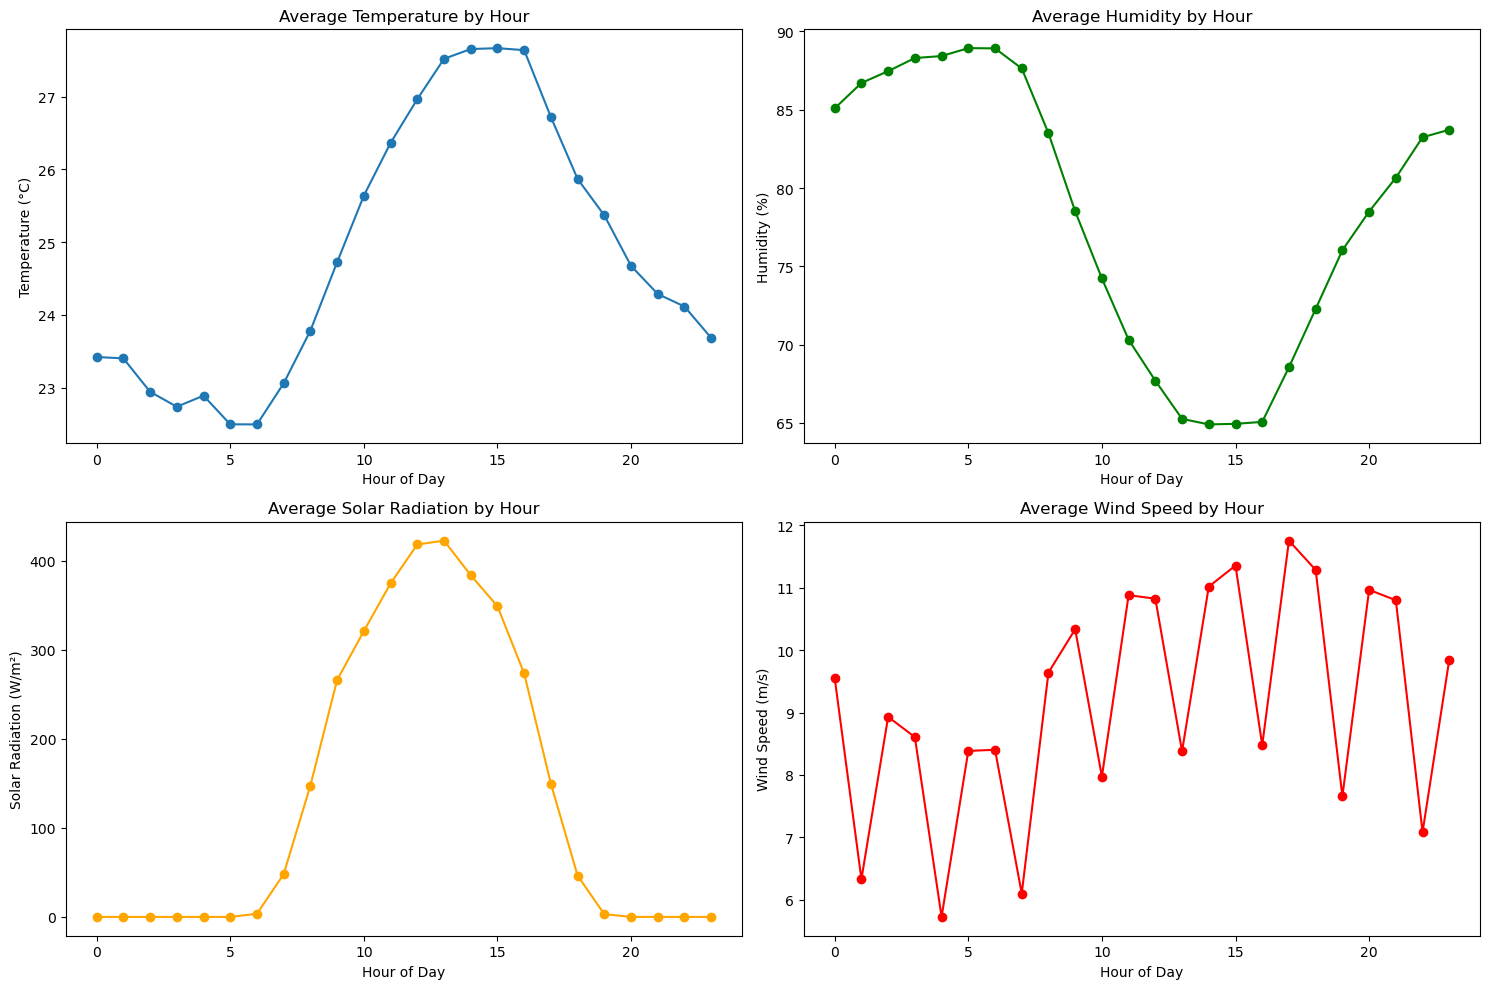


✅ Temporal features completed!
📊 Current shape: (87696, 50)


In [6]:
# Create advanced temporal features for hourly forecasting
print("⏰ CREATING HOURLY TEMPORAL FEATURES")
print("=" * 40)

# Cyclical encoding for hourly patterns
print("🔄 Creating cyclical time encodings...")

# Hour of day (24-hour cycle)
df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['hour'] / 24)
df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['hour'] / 24)

# Day of week (7-day cycle)
df_hourly['dow_sin'] = np.sin(2 * np.pi * df_hourly['day_of_week'] / 7)
df_hourly['dow_cos'] = np.cos(2 * np.pi * df_hourly['day_of_week'] / 7)

# Day of year (365-day cycle)
df_hourly['doy_sin'] = np.sin(2 * np.pi * df_hourly['day_of_year'] / 365.25)
df_hourly['doy_cos'] = np.cos(2 * np.pi * df_hourly['day_of_year'] / 365.25)

# Month (12-month cycle)
df_hourly['month_sin'] = np.sin(2 * np.pi * df_hourly['month'] / 12)
df_hourly['month_cos'] = np.cos(2 * np.pi * df_hourly['month'] / 12)

print("✅ Cyclical encodings created!")

# Time-based categorical features
print("\n📅 Creating time-based categorical features...")

# Hour categories
df_hourly['hour_category'] = pd.cut(df_hourly['hour'], 
                                   bins=[0, 6, 12, 18, 24], 
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                   include_lowest=True)

# Workday indicator
df_hourly['is_workday'] = (df_hourly['day_of_week'] < 5).astype(int)

# Season categories
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_hourly['season'] = df_hourly['month'].apply(get_season)

# Business hours indicator
df_hourly['is_business_hours'] = ((df_hourly['hour'] >= 8) & 
                                 (df_hourly['hour'] <= 17) & 
                                 (df_hourly['is_workday'] == 1)).astype(int)

print("✅ Time-based categoricals created!")

# Time since features (useful for trend analysis)
print("\n📈 Creating time-since features...")

start_date = df_hourly.index.min()
df_hourly['hours_since_start'] = ((df_hourly.index - start_date).total_seconds() / 3600).astype(int)
df_hourly['days_since_start'] = ((df_hourly.index - start_date).days).astype(int)

print("✅ Time-since features created!")

# Visualize cyclical patterns
print("\n📊 Visualizing diurnal patterns...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature by hour
hourly_temp = df_hourly.groupby('hour')['temp'].mean()
axes[0,0].plot(hourly_temp.index, hourly_temp.values, marker='o')
axes[0,0].set_title('Average Temperature by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Temperature (°C)')

# Humidity by hour
hourly_humidity = df_hourly.groupby('hour')['humidity'].mean()
axes[0,1].plot(hourly_humidity.index, hourly_humidity.values, marker='o', color='green')
axes[0,1].set_title('Average Humidity by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Humidity (%)')

# Solar radiation by hour
hourly_solar = df_hourly.groupby('hour')['solarradiation'].mean()
axes[1,0].plot(hourly_solar.index, hourly_solar.values, marker='o', color='orange')
axes[1,0].set_title('Average Solar Radiation by Hour')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Solar Radiation (W/m²)')

# Wind speed by hour
hourly_wind = df_hourly.groupby('hour')['windspeed'].mean()
axes[1,1].plot(hourly_wind.index, hourly_wind.values, marker='o', color='red')
axes[1,1].set_title('Average Wind Speed by Hour')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

print(f"\n✅ Temporal features completed!")
print(f"📊 Current shape: {df_hourly.shape}")

## 3️⃣ Multi-Horizon Lag Features

In [7]:
# Create comprehensive lag features for multi-horizon forecasting
print("📈 CREATING MULTI-HORIZON LAG FEATURES")
print("=" * 42)

# Define lag periods for different forecasting horizons
lag_periods = {
    'short_term': [1, 2, 3, 6],           # 1-6 hours (immediate past)
    'daily_pattern': [24, 48, 72],        # 1-3 days (daily cycles)
    'weekly_pattern': [168, 336],         # 1-2 weeks (weekly cycles)
    'seasonal': [24*30, 24*60, 24*90]     # Monthly, bi-monthly, quarterly
}

# Core weather variables for lag features
lag_variables = ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover', 
                'visibility', 'solarradiation', 'winddir']

print(f"🎯 Creating lag features for {len(lag_variables)} variables...")
print(f"⏰ Lag patterns: {sum(len(v) for v in lag_periods.values())} different lags")

# Create lag features
for category, lags in lag_periods.items():
    print(f"\n🔄 Processing {category} lags: {lags}")
    
    for var in lag_variables:
        if var in df_hourly.columns:
            for lag in lags:
                lag_col = f"{var}_lag_{lag}h"
                df_hourly[lag_col] = df_hourly[var].shift(lag)
                
    print(f"   ✅ {category} lags created")

print(f"\n✅ Lag features completed!")
print(f"📊 Current shape: {df_hourly.shape}")

# Create rolling statistics for different windows
print("\n📊 CREATING ROLLING STATISTICS")
print("=" * 32)

rolling_windows = [6, 12, 24, 168]  # 6h, 12h, 24h, 1week
rolling_stats = ['mean', 'std', 'min', 'max']

for var in ['temp', 'humidity', 'windspeed', 'sealevelpressure']:
    if var in df_hourly.columns:
        print(f"🌡️ Processing {var} rolling features...")
        
        for window in rolling_windows:
            for stat in rolling_stats:
                col_name = f"{var}_rolling_{window}h_{stat}"
                if stat == 'mean':
                    df_hourly[col_name] = df_hourly[var].rolling(window=window, min_periods=1).mean()
                elif stat == 'std':
                    df_hourly[col_name] = df_hourly[var].rolling(window=window, min_periods=1).std()
                elif stat == 'min':
                    df_hourly[col_name] = df_hourly[var].rolling(window=window, min_periods=1).min()
                elif stat == 'max':
                    df_hourly[col_name] = df_hourly[var].rolling(window=window, min_periods=1).max()
        
        print(f"   ✅ {len(rolling_windows) * len(rolling_stats)} rolling features created")

print(f"\n✅ Rolling statistics completed!")
print(f"📊 Current shape: {df_hourly.shape}")

📈 CREATING MULTI-HORIZON LAG FEATURES
🎯 Creating lag features for 8 variables...
⏰ Lag patterns: 12 different lags

🔄 Processing short_term lags: [1, 2, 3, 6]
   ✅ short_term lags created

🔄 Processing daily_pattern lags: [24, 48, 72]
   ✅ daily_pattern lags created

🔄 Processing weekly_pattern lags: [168, 336]
   ✅ weekly_pattern lags created

🔄 Processing seasonal lags: [720, 1440, 2160]
   ✅ seasonal lags created

✅ Lag features completed!
📊 Current shape: (87696, 146)

📊 CREATING ROLLING STATISTICS
🌡️ Processing temp rolling features...
   ✅ 16 rolling features created
🌡️ Processing humidity rolling features...
   ✅ 16 rolling features created
🌡️ Processing windspeed rolling features...
   ✅ 16 rolling features created
🌡️ Processing sealevelpressure rolling features...
   ✅ 16 rolling features created

✅ Rolling statistics completed!
📊 Current shape: (87696, 210)
   ✅ 16 rolling features created
🌡️ Processing windspeed rolling features...
   ✅ 16 rolling features created
🌡️ Process

## 4️⃣ Weather Interactions & Physics-Based Features

In [8]:
# Create weather interaction features and physics-based indicators
print("🌤️ CREATING WEATHER INTERACTIONS & PHYSICS FEATURES")
print("=" * 52)

# Temperature-based interactions
print("🌡️ Temperature interactions...")
df_hourly['temp_humidity_ratio'] = df_hourly['temp'] / (df_hourly['humidity'] + 1)
df_hourly['temp_dewpoint_spread'] = df_hourly['temp'] - df_hourly['dew']
df_hourly['heat_index'] = df_hourly['temp'] + 0.5 * (df_hourly['humidity'] - 50)  # Simplified heat index

# Wind-related interactions
print("💨 Wind interactions...")
df_hourly['wind_chill_factor'] = df_hourly['temp'] - 0.7 * df_hourly['windspeed']
df_hourly['wind_pressure_gradient'] = df_hourly['windspeed'] * df_hourly['sealevelpressure'] / 1000

# Convert wind direction to components
df_hourly['wind_north'] = df_hourly['windspeed'] * np.cos(np.radians(df_hourly['winddir']))
df_hourly['wind_east'] = df_hourly['windspeed'] * np.sin(np.radians(df_hourly['winddir']))

# Pressure-based features
print("📊 Pressure features...")
df_hourly['pressure_tendency_1h'] = df_hourly['sealevelpressure'].diff(1)
df_hourly['pressure_tendency_3h'] = df_hourly['sealevelpressure'].diff(3)
df_hourly['pressure_tendency_6h'] = df_hourly['sealevelpressure'].diff(6)

# Solar radiation interactions
print("☀️ Solar interactions...")
df_hourly['solar_efficiency'] = np.where(df_hourly['solarradiation'] > 0, 
                                        df_hourly['temp'] / (df_hourly['solarradiation'] + 1), 0)
df_hourly['cloud_solar_interaction'] = df_hourly['cloudcover'] * df_hourly['solarradiation'] / 100

# Visibility-related features
print("👁️ Visibility features...")
df_hourly['visibility_humidity_ratio'] = df_hourly['visibility'] / (df_hourly['humidity'] + 1)
df_hourly['fog_probability'] = np.where((df_hourly['visibility'] < 5) & 
                                       (df_hourly['humidity'] > 85), 1, 0)

# Atmospheric stability indicators
print("🌀 Atmospheric stability...")
df_hourly['stability_index'] = (df_hourly['temp'] - df_hourly['dew']) / df_hourly['windspeed'].clip(lower=0.1)
df_hourly['convection_potential'] = df_hourly['temp'] * df_hourly['humidity'] / 100

# Comfort indices
print("😌 Comfort indices...")
df_hourly['comfort_index'] = 100 - ((df_hourly['temp'] - 22) ** 2) / 4 - df_hourly['humidity'] / 2
df_hourly['thermal_sensation'] = 1.76 + df_hourly['temp'] * 1.4 - df_hourly['windspeed'] * 0.29

print("✅ Weather interactions completed!")

# Energy-related features (relevant for building/agricultural applications)
print("\n⚡ Energy-related features...")
df_hourly['cooling_degree_hours'] = np.maximum(df_hourly['temp'] - 18, 0)  # Base 18°C
df_hourly['heating_degree_hours'] = np.maximum(18 - df_hourly['temp'], 0)  # Base 18°C
df_hourly['evapotranspiration_index'] = (df_hourly['temp'] + 5) * df_hourly['solarradiation'] / (df_hourly['humidity'] + 10)

print("✅ Energy features completed!")
print(f"📊 Current shape: {df_hourly.shape}")

🌤️ CREATING WEATHER INTERACTIONS & PHYSICS FEATURES
🌡️ Temperature interactions...
💨 Wind interactions...
📊 Pressure features...
☀️ Solar interactions...
👁️ Visibility features...
🌀 Atmospheric stability...
😌 Comfort indices...
✅ Weather interactions completed!

⚡ Energy-related features...
✅ Energy features completed!
📊 Current shape: (87696, 231)


## 5️⃣ Trend Analysis & Change Detection

In [9]:
# Create trend analysis and change detection features
print("📈 CREATING TREND ANALYSIS & CHANGE DETECTION")
print("=" * 46)

# Short-term trends (1-6 hours)
print("⚡ Short-term trends...")
for var in ['temp', 'humidity', 'sealevelpressure', 'windspeed']:
    if var in df_hourly.columns:
        # Rate of change
        df_hourly[f'{var}_change_1h'] = df_hourly[var].diff(1)
        df_hourly[f'{var}_change_3h'] = df_hourly[var].diff(3)
        df_hourly[f'{var}_change_6h'] = df_hourly[var].diff(6)
        
        # Acceleration (second derivative)
        df_hourly[f'{var}_acceleration_1h'] = df_hourly[f'{var}_change_1h'].diff(1)
        
        # Trend direction
        df_hourly[f'{var}_trend_6h'] = np.where(df_hourly[f'{var}_change_6h'] > 0.1, 1,
                                               np.where(df_hourly[f'{var}_change_6h'] < -0.1, -1, 0))

print("✅ Short-term trends completed!")

# Medium-term trends (daily patterns)
print("\n📅 Daily trend patterns...")
for var in ['temp', 'humidity', 'sealevelpressure']:
    if var in df_hourly.columns:
        # Daily change
        df_hourly[f'{var}_daily_change'] = df_hourly[var].diff(24)
        
        # Compare to same hour yesterday
        df_hourly[f'{var}_vs_yesterday'] = df_hourly[var] - df_hourly[var].shift(24)
        
        # Daily volatility
        df_hourly[f'{var}_daily_volatility'] = df_hourly[var].rolling(24).std()

print("✅ Daily trends completed!")

# Weather pattern changes
print("\n🌤️ Weather pattern changes...")

# Rapid weather changes (early warning indicators)
df_hourly['temp_rapid_drop'] = np.where(df_hourly['temp_change_3h'] < -3, 1, 0)
df_hourly['temp_rapid_rise'] = np.where(df_hourly['temp_change_3h'] > 3, 1, 0)
df_hourly['pressure_rapid_drop'] = np.where(df_hourly['pressure_tendency_3h'] < -3, 1, 0)
df_hourly['pressure_rapid_rise'] = np.where(df_hourly['pressure_tendency_3h'] > 3, 1, 0)

# Wind direction changes
df_hourly['wind_direction_change'] = df_hourly['winddir'].diff(1).abs()
df_hourly['wind_direction_change'] = np.where(df_hourly['wind_direction_change'] > 180, 
                                             360 - df_hourly['wind_direction_change'], 
                                             df_hourly['wind_direction_change'])

# Weather stability indicators
df_hourly['weather_stability'] = (df_hourly['temp_change_6h'].abs() + 
                                 df_hourly['pressure_tendency_6h'].abs() / 10 + 
                                 df_hourly['humidity_change_6h'].abs() / 10)

print("✅ Weather pattern changes completed!")

# Seasonal anomalies
print("\n🌿 Seasonal anomaly detection...")

# Calculate seasonal baselines (by month and hour)
seasonal_baselines = df_hourly.groupby(['month', 'hour']).agg({
    'temp': 'mean',
    'humidity': 'mean', 
    'sealevelpressure': 'mean'
}).reset_index()

# Merge back and calculate anomalies
df_temp = df_hourly.reset_index()
df_temp = df_temp.merge(seasonal_baselines, on=['month', 'hour'], suffixes=('', '_seasonal_mean'))

df_hourly['temp_seasonal_anomaly'] = df_temp['temp'] - df_temp['temp_seasonal_mean']
df_hourly['humidity_seasonal_anomaly'] = df_temp['humidity'] - df_temp['humidity_seasonal_mean']
df_hourly['pressure_seasonal_anomaly'] = df_temp['sealevelpressure'] - df_temp['sealevelpressure_seasonal_mean']

print("✅ Seasonal anomalies completed!")

print(f"\n✅ Trend analysis completed!")
print(f"📊 Current shape: {df_hourly.shape}")

📈 CREATING TREND ANALYSIS & CHANGE DETECTION
⚡ Short-term trends...
✅ Short-term trends completed!

📅 Daily trend patterns...
✅ Daily trends completed!

🌤️ Weather pattern changes...
✅ Weather pattern changes completed!

🌿 Seasonal anomaly detection...
✅ Seasonal anomalies completed!

✅ Trend analysis completed!
📊 Current shape: (87696, 269)
✅ Seasonal anomalies completed!

✅ Trend analysis completed!
📊 Current shape: (87696, 269)


## 6️⃣ Feature Selection & Export

In [10]:
# Feature selection and final data preparation
print("🎯 FEATURE SELECTION & FINAL PREPARATION")
print("=" * 43)

# Handle infinite and NaN values
print("🔧 Cleaning infinite and NaN values...")

# Replace inf values with NaN
df_hourly.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaN values (mostly from lag features at the beginning)
numeric_cols = df_hourly.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_hourly[col].isnull().sum() > 0:
        # Use forward fill then backward fill for lag features
        df_hourly[col] = df_hourly[col].fillna(method='ffill').fillna(method='bfill')

print(f"✅ Cleaned {len(numeric_cols)} numeric columns")

# Feature categorization
print("\n📊 Categorizing features...")

target_vars = ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover']

# Base weather features
base_features = ['temp', 'feelslike', 'dew', 'humidity', 'windspeed', 'winddir', 'windgust',
                'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'uvindex']

# Temporal features
temporal_features = [col for col in df_hourly.columns if any(x in col for x in 
                    ['hour_', 'dow_', 'doy_', 'month_', 'is_', 'season', 'category'])]

# Lag features
lag_features = [col for col in df_hourly.columns if '_lag_' in col]

# Rolling features
rolling_features = [col for col in df_hourly.columns if '_rolling_' in col]

# Interaction features
interaction_features = [col for col in df_hourly.columns if any(x in col for x in 
                       ['_ratio', '_spread', '_index', '_factor', '_gradient', '_interaction', 
                        '_efficiency', '_north', '_east', '_probability'])]

# Trend features
trend_features = [col for col in df_hourly.columns if any(x in col for x in 
                 ['_change_', '_acceleration_', '_trend_', '_daily_', '_vs_', '_volatility_',
                  '_tendency_', '_rapid_', '_stability', '_anomaly'])]

feature_groups = {
    'base': base_features,
    'temporal': temporal_features,
    'lag': lag_features,
    'rolling': rolling_features,
    'interaction': interaction_features,
    'trend': trend_features
}

print(f"📋 Feature categorization:")
for group, features in feature_groups.items():
    print(f"   {group}: {len(features)} features")

total_features = sum(len(features) for features in feature_groups.values())
print(f"\n📊 Total engineered features: {total_features}")
print(f"📏 Final dataset shape: {df_hourly.shape}")

# Data quality report
print(f"\n📈 FINAL DATA QUALITY REPORT")
print("=" * 30)
print(f"Missing values: {df_hourly.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(df_hourly.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Memory usage: {df_hourly.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Export feature-engineered dataset
print(f"\n💾 EXPORTING DATASETS")
print("=" * 20)

# Export full dataset
full_output_path = os.path.join(FEATURES_OUTPUT_PATH, 'hanoi_weather_hourly_features.csv')
df_export = df_hourly.reset_index()
df_export.to_csv(full_output_path, index=False)

print(f"✅ Full dataset saved: {full_output_path}")
print(f"📊 Shape: {df_export.shape}")
print(f"💽 Size: {os.path.getsize(full_output_path) / 1024**2:.2f} MB")

# Export feature metadata
feature_metadata = {
    'total_features': total_features,
    'feature_groups': {k: len(v) for k, v in feature_groups.items()},
    'target_variables': target_vars,
    'date_range': {
        'start': str(df_hourly.index.min()),
        'end': str(df_hourly.index.max()),
        'duration_days': (df_hourly.index.max() - df_hourly.index.min()).days
    },
    'lag_periods': lag_periods,
    'rolling_windows': rolling_windows
}

import json
metadata_path = os.path.join(FEATURES_OUTPUT_PATH, 'hourly_feature_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)

print(f"✅ Metadata saved: {metadata_path}")

print(f"\n🎉 HOURLY FEATURE ENGINEERING COMPLETED!")
print("=" * 45)
print("✅ Ready for multi-horizon model training!")

# Display sample of engineered features
print(f"\n📋 SAMPLE ENGINEERED FEATURES:")
print("=" * 32)
sample_features = (base_features[:3] + temporal_features[:3] + 
                  lag_features[:3] + interaction_features[:3])
df_hourly[sample_features].tail()

🎯 FEATURE SELECTION & FINAL PREPARATION
🔧 Cleaning infinite and NaN values...
✅ Cleaned 258 numeric columns

📊 Categorizing features...
📋 Feature categorization:
   base: 12 features
   temporal: 15 features
   lag: 96 features
   rolling: 64 features
   interaction: 14 features
   trend: 40 features

📊 Total engineered features: 241
📏 Final dataset shape: (87696, 269)

📈 FINAL DATA QUALITY REPORT
Missing values: 263088
✅ Cleaned 258 numeric columns

📊 Categorizing features...
📋 Feature categorization:
   base: 12 features
   temporal: 15 features
   lag: 96 features
   rolling: 64 features
   interaction: 14 features
   trend: 40 features

📊 Total engineered features: 241
📏 Final dataset shape: (87696, 269)

📈 FINAL DATA QUALITY REPORT
Missing values: 263088
Infinite values: 0
Memory usage: 221.29 MB

💾 EXPORTING DATASETS
Infinite values: 0
Memory usage: 221.29 MB

💾 EXPORTING DATASETS
✅ Full dataset saved: ../data/processed/hanoi_weather_hourly_features.csv
📊 Shape: (87696, 270)
💽 Si

,temp,feelslike,dew,hour_sin,hour_cos,dow_sin,temp_lag_1h,temp_lag_2h,temp_lag_3h,temp_humidity_ratio,temp_dewpoint_spread,heat_index
datetime_processed,,,,,,,,,,,,
2025-09-27 19:00:00,29.0,33.5,24.0,-0.965926,0.258819,-0.974928,31.0,32.0,34.0,0.384310,5.0,41.230
2025-09-27 20:00:00,29.0,34.4,25.0,-0.866025,0.500000,-0.974928,29.0,31.0,32.0,0.362274,4.0,43.525
2025-09-27 21:00:00,28.0,32.6,25.0,-0.707107,0.707107,-0.974928,29.0,29.0,31.0,0.330267,3.0,44.890
2025-09-27 22:00:00,28.0,32.6,25.0,-0.500000,0.866025,-0.974928,28.0,29.0,29.0,0.330267,3.0,44.890
2025-09-27 23:00:00,27.0,31.0,26.0,-0.258819,0.965926,-0.974928,28.0,28.0,29.0,0.283405,1.0,49.135


# 🔧 Hanoi Hourly Weather Feature Engineering - Step 4

This notebook creates advanced features for hourly weather forecasting, focusing on temporal patterns, weather interactions, and predictive indicators specific to hourly data characteristics.

**Hourly Features Strategy:**
- **Diurnal Patterns**: Hour-specific cycles, day/night transitions
- **Multi-horizon Lags**: Recent hours, daily patterns, weekly patterns
- **Weather Interactions**: Temperature-humidity, wind-pressure relationships
- **Trend Analysis**: Short-term and medium-term weather trends
- **Seasonal Encoding**: Cyclical time features for hourly predictions

---